Nombre: López Fabián Jesús Manuel

Grupo: 5AV1

Carrera: Licenciatura en Ciencia de Datos

Fecha última modificación: 13/06/2024

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [92]:
# Selecciona el estilo 'seaborn-v0_8' para los gráficos
plt.style.use('seaborn-v0_8')

In [93]:
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x

    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 

    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).

    An N-dimensional output map is generated by y = sammon(x,n) .

    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):

       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'

    The default options are retrieved by calling sammon(x) with no
    parameters.

    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot

    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].

    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.

    Copyright   : (c) Dr Gavin C. Cawley, November 2007.

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA

    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

In [94]:
doctor_visits = pd.read_csv("Data/DoctorVisits.csv")
doctor_visits.head()

,rownames,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
0,1,1,female,0.19,0.55,1,4,1,yes,no,no,no,no
1,2,1,female,0.19,0.45,1,2,1,yes,no,no,no,no
2,3,1,male,0.19,0.90,3,0,0,no,no,no,no,no
3,4,1,male,0.19,0.15,1,0,0,no,no,no,no,no
4,5,1,male,0.19,0.45,2,5,1,no,no,no,yes,no


In [95]:
doctor_visits.isna().sum()

rownames     0
visits       0
gender       0
age          0
income       0
illness      0
reduced      0
health       0
private      0
freepoor     0
freerepat    0
nchronic     0
lchronic     0
dtype: int64

### Transformación de datos
Convertir las dimensiones categóricas binarias en dimensiones numéricas.

Conjunto de datos previo a la transformación:

In [96]:
doctor_visits.head()

,rownames,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
0,1,1,female,0.19,0.55,1,4,1,yes,no,no,no,no
1,2,1,female,0.19,0.45,1,2,1,yes,no,no,no,no
2,3,1,male,0.19,0.90,3,0,0,no,no,no,no,no
3,4,1,male,0.19,0.15,1,0,0,no,no,no,no,no
4,5,1,male,0.19,0.45,2,5,1,no,no,no,yes,no


In [97]:
def encontrar_binarias(data: pd.DataFrame) -> list:
    variables_bin = []
    for col in data.columns:
        if(len(data[col].unique()) == 2):
            variables_bin.append(col)
        
    return variables_bin
        

In [98]:
variables_binarias = encontrar_binarias(doctor_visits)
variables_binarias

['gender', 'private', 'freepoor', 'freerepat', 'nchronic', 'lchronic']

'gender' es la unica variable binaria que contiene un valor distinto a 'yes' o 'no'

In [99]:
for var in variables_binarias:
    if var == "gender":
        doctor_visits[var] = doctor_visits[var].apply(lambda x: 0 if x == "female" else 1)
    else:
        doctor_visits[var] = doctor_visits[var].apply(lambda x: 0 if x == "no" else 1)

Conjunto de datos despues de la transformación: 

In [100]:
doctor_visits.head()

,rownames,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
0,1,1,0,0.19,0.55,1,4,1,1,0,0,0,0
1,2,1,0,0.19,0.45,1,2,1,1,0,0,0,0
2,3,1,1,0.19,0.90,3,0,0,0,0,0,0,0
3,4,1,1,0.19,0.15,1,0,0,0,0,0,0,0
4,5,1,1,0.19,0.45,2,5,1,0,0,0,1,0


### Creación de nuevo espacio dimensional a través de método de Sammon, visualización de nuevo espacio dimensional, medición de tiempo necesario para realizar la proyección, y despliegue del resultado de la función de estrés.

a) Utilizando en el método los datos originales.

In [106]:
# Seleccionar las características relevantes, excluyendo `rownames`
features = doctor_visits.iloc[:, 1:].values
features = pd.DataFrame(features).drop_duplicates()

n_dimensiones = 2 
[y, E] = sammon(features, n_dimensiones)

print('Coordenadas reducidas:')
print(y)
print('Stress (error de Sammon):')
print(E)

epoch = 1 : E = 0.0602551736
epoch = 2 : E = 0.0594982106
epoch = 3 : E = 0.0593167533
epoch = 4 : E = 0.0589046476
epoch = 5 : E = 0.0588967202
epoch = 6 : E = 0.0586165234
epoch = 7 : E = 0.0581472116
epoch = 8 : E = 0.0580378688
epoch = 9 : E = 0.0570661665
epoch = 10 : E = 0.0568935752
epoch = 11 : E = 0.0559707473
epoch = 12 : E = 0.0559546013
epoch = 13 : E = 0.0556955907
epoch = 14 : E = 0.0556244365
epoch = 15 : E = 0.0553580167
epoch = 16 : E = 0.0552444798
epoch = 17 : E = 0.0549628696
epoch = 18 : E = 0.0537142210
epoch = 19 : E = 0.0520535076
epoch = 20 : E = 0.0519297584
epoch = 21 : E = 0.0503867662
epoch = 22 : E = 0.0502609833
epoch = 23 : E = 0.0502263415
epoch = 24 : E = 0.0499570649
epoch = 25 : E = 0.0498582677
epoch = 26 : E = 0.0496791266
epoch = 27 : E = 0.0493682363
epoch = 28 : E = 0.0489940892
epoch = 29 : E = 0.0489858096
epoch = 30 : E = 0.0489584137
epoch = 31 : E = 0.0489207231
epoch = 32 : E = 0.0477763036
epoch = 33 : E = 0.0476415308
epoch = 34 : E = 0.

In [111]:
print(f"Estres: {E}")

Estres: 0.015522441003205822


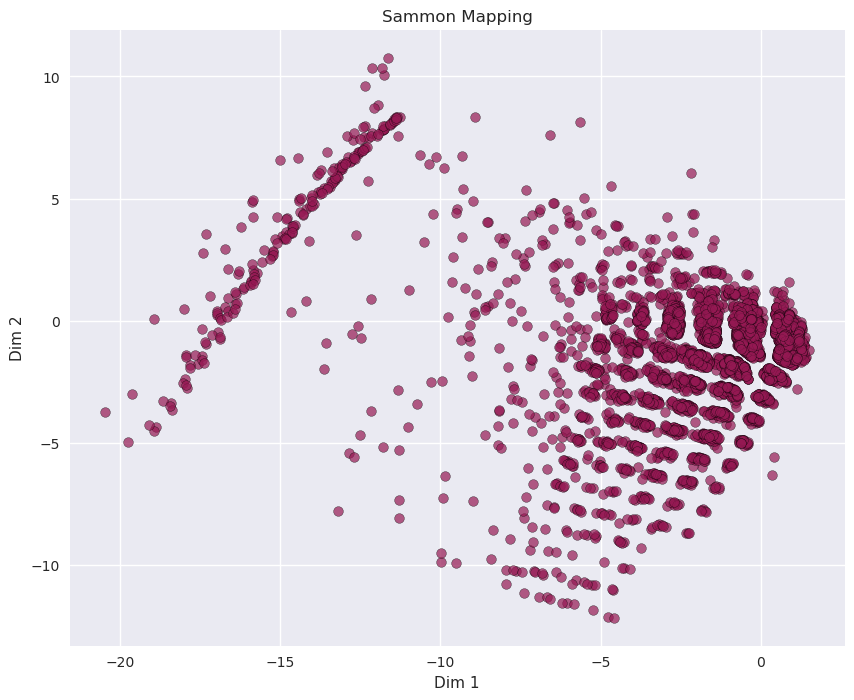

In [118]:
plt.figure(figsize=(10, 8))
plt.scatter(y[:, 0], y[:, 1], c='#951953', edgecolor='k', alpha=0.7)
plt.title('Sammon Mapping')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.show()

b) Utilizando en el método los datos transformados a través de PCA.

In [152]:
n_dimensiones = 2 
[y_pca, E_pca] = sammon(doctor_visits.drop_duplicates(), n_dimensiones, init = 'pca', maxiter = 100)

print('Coordenadas reducidas:')
print(y_pca)
print('Stress (error de Sammon):')
print(E_pca)

epoch = 1 : E = 0.0000003058
epoch = 2 : E = 0.0000003052
epoch = 3 : E = 0.0000003000
epoch = 4 : E = 0.0000002972
epoch = 5 : E = 0.0000002933
epoch = 6 : E = 0.0000002930
epoch = 7 : E = 0.0000002920
epoch = 8 : E = 0.0000002813
epoch = 9 : E = 0.0000002797
epoch = 10 : E = 0.0000002781
epoch = 11 : E = 0.0000002775
epoch = 12 : E = 0.0000002774
epoch = 13 : E = 0.0000002774
epoch = 14 : E = 0.0000002768
epoch = 15 : E = 0.0000002758
epoch = 16 : E = 0.0000002752
epoch = 17 : E = 0.0000002750
epoch = 18 : E = 0.0000002731
epoch = 19 : E = 0.0000002726
epoch = 20 : E = 0.0000002701
epoch = 21 : E = 0.0000002698
epoch = 22 : E = 0.0000002679
epoch = 23 : E = 0.0000002637
epoch = 24 : E = 0.0000002634
epoch = 25 : E = 0.0000002620
epoch = 26 : E = 0.0000002613
epoch = 27 : E = 0.0000002611
epoch = 28 : E = 0.0000002610
epoch = 29 : E = 0.0000002587
epoch = 30 : E = 0.0000002584
epoch = 31 : E = 0.0000002359
epoch = 32 : E = 0.0000002358
epoch = 33 : E = 0.0000002358
epoch = 34 : E = 0.

In [ ]:
print(f"Estres: {E_pca}")

Estres: 2.7012464419742596e-07


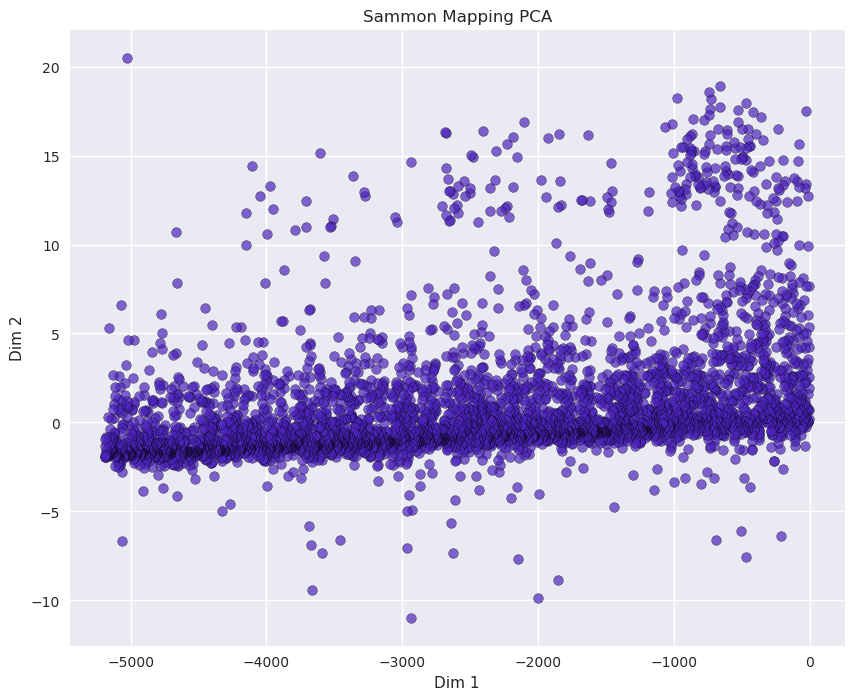

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(y_pca[:, 0], y_pca[:, 1], c='#4C24BD', edgecolor='k', alpha=0.7)
plt.title('Sammon Mapping PCA')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.grid(True)
plt.show()